In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from ROOT import TVector3
import perform_calibrations as pc #import perform calibration package to get data
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import ROOT
import array
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
rc('text', usetex=True)

In [8]:
t = pc.tpc_calibration()

In [9]:
uncorrected_recoils = t.calibrate_recoils(corrected_energy = True, corrected_length = 0) #Use 'track_energy' for uncorrected
corrected_recoils = t.calibrate_recoils(corrected_energy = True, corrected_length = 0)

/Users/vahsengrouplaptop/workspace/jeff_workspace/calibration/perform_calibrations.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['full_corrected_energy'][index] = dataframe['saturation_corrected_energy'][index] #truncate full correction range


### Apply He recoil band preliminary cuts (to train double gaussian fitter)

In [4]:
def apply_He_band_cuts(df, ecor = 'corrected'): #Cuts to train double Gaussian fit
    if ecor != 'corrected':
        if tpc == 'iiwi':
            cut_min = np.array([3.18181818e-06, 1.41363636e-02, -1.52272727e+01])
            cut_max = np.array([7.34848485e-06, 1.28863636e-02, -8.14393939e+00])
        elif tpc == 'humu':
            cut_min = np.array([2.48484848e-06, 1.45636364e-02, -1.69393939e+01])
            cut_max = np.array([2.500e-06, 3.325e-02, -2.875e+01])
        elif tpc == 'nene':
            cut_min = np.array([3.93939394e-06, 8.45454545e-03, -1.07575758e+01])
            cut_max = np.array([3.13636364e-06, 3.80772727e-02, -3.87954545e+01])
        elif tpc == 'tako':
            cut_min = np.array([5.0e-06, 6.5e-03, -7.5e+00])
            cut_max = np.array([6.51515152e-06, 2.51363636e-02, -2.35606061e+01])
        elif tpc == 'palila':
            cut_min = np.array([5.0e-06, 6.5e-03, -7.5e+00])
            cut_max = np.array([6.13636364e-06, 2.79772727e-02, -2.82954545e+01])
        else:
            cut_min = np.array([4.66666667e-06, -4.60000000e-03, 6.33333333e+00])
            cut_max = np.array([9.01515152e-06, 8.38636364e-03, -2.31060606e+00])
        ekey = 'track_energy'
        df = df.loc[df[ekey]>8]
    else:
        if tpc == 'iiwi':
            cut_min = np.array([3.56060606e-06, 2.12954545e-02, -2.54924242e+01])
            cut_max = np.array([8.48484848e-06,  1.43636364e-02, -3.93939394e+00])
        elif tpc == 'humu':
            cut_min = np.array([1.36363636e-06, 3.17727273e-02, -3.29545455e+01])
            cut_max = np.array([5.45454545e-06, 2.70909091e-02, -1.68181818e+01])
        elif tpc == 'nene':
            cut_min = np.array([5.60606061e-06, 3.95454545e-03, 7.57575758e-02])
            cut_max = np.array([1.03030303e-05, 6.72727273e-03, 8.78787879e+00])
        elif tpc == 'tako':
            cut_min = np.array([6.39393939e-06, 5.64545455e-03, 1.92424242e+00])
            cut_max = np.array([7.72727273e-06, 3.00454545e-02, -1.34090909e+01])
        elif tpc == 'palila':
            cut_min = np.array([6.60606061e-06, 7.25454545e-03, -7.42424242e+00])
            cut_max = np.array([1.01818182e-05, 1.72363636e-02, -1.07272727e+01])
        else:
            cut_min = np.array([2.96969697e-06, 1.25272727e-02, -1.18787879e+01])
            cut_max = np.array([9.75757576e-06, 1.40181818e-02, 5.96969697e+00])
        ekey = 'full_corrected_energy'
        df = df.loc[df[ekey]>10]
    df_red = df.loc[(df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2]))
                        & (df[ekey]<(cut_max[0]*df['length']**2  +cut_max[1]*df['length']+cut_max[2]))]
    df = df.loc[df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2])]
    return df, df_red

uncorrected_red = {}
corrected_red = {}
tpcs = corrected_recoils.keys()
for tpc in tpcs:
    uncorrected_recoils[tpc], uncorrected_red[tpc] = apply_He_band_cuts(corrected_recoils[tpc], ecor = 'uncorrected')
    corrected_recoils[tpc], corrected_red[tpc] = apply_He_band_cuts(corrected_recoils[tpc], ecor = 'corrected')

### Visualize EvL

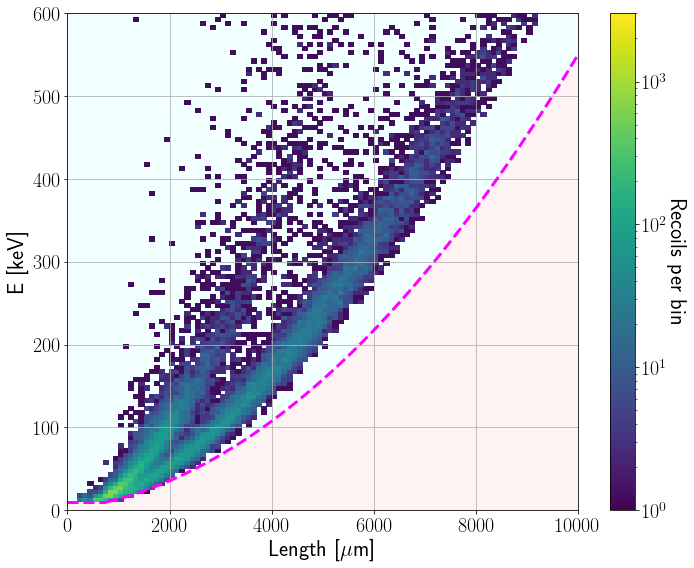

In [5]:
import matplotlib
i = 1
fig = plt.figure(figsize = (10,8))
cmap = plt.cm.viridis
cmap.set_under(color='white')
#vmin = 0.1
xm = 10000
ym = 600
nbinsx = 100
nbinsy = 120
h = {}
image = {}
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=22)
plt.rc('axes', titlesize=22)
x_plt = np.linspace(0,20000,20001)
x_plt1 = np.linspace(0,760,761)
x_plt2 = np.linspace(760,20000,19251)
x = np.array([1700, 2500, 10000])
ymin = np.array([28, 50, 550])
ymax = np.array([50, 95, 900])
cut_min2 = np.polyfit(x,ymin, 2)
cut_max2 = np.polyfit(x, ymax, 2)
for tpc in ['tako']:
    plt.subplot(1,1,i)
    #if tpc == 'tako':
    #    ymin = np.array([30, 56, 190])
    #    ymax = np.array([60, 110, 330])
    #cut_min2 = np.polyfit(x,ymin, 2)
    #cut_max2 = np.polyfit(x, ymax, 2)
    h[tpc+'_cor'], xedges, yedges, image[tpc+'_cor'] = plt.hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=3000), cmap=cmap)
    #plt.fill_between(x_plt, cut_min2[0]*x_plt**2+cut_min2[1]*x_plt+cut_min2[2], cut_max2[0]*x_plt**2+cut_max2[1]*x_plt+cut_max2[2], color = 'magenta', linewidth = 2, alpha = 0.3, label = 'He recoil training region')
    plt.fill_between(list(x_plt1)+list(x_plt2),[10 for i in x_plt1] + list(cut_min2[0]*x_plt2**2+cut_min2[1]*x_plt2+cut_min2[2]), 600, color = 'cyan', alpha = 0.05, label = 'He recoil training region')
    plt.fill_between(list(x_plt1)+list(x_plt2), 0, [10 for i in x_plt1] + list(cut_min2[0]*x_plt2**2+cut_min2[1]*x_plt2+cut_min2[2]), color = 'red', alpha = 0.05, label = 'He recoil training region')
    plt.plot(x_plt1, [10 for i in x_plt1], '--', color = 'magenta', linewidth = 3, alpha = 1)
    plt.plot(x_plt2, cut_min2[0]*x_plt2**2+cut_min2[1]*x_plt2+cut_min2[2], '--', color = 'magenta', linewidth = 3, alpha = 1, label = 'Recoil cutoff region')
    plt.ylim(0,ym)
    plt.xlim(0,xm)
    #plt.title('%s Corrected energy vs length'%(tpc.upper()))
    #plt.title('Corrected Energy')
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    #custom_lines = [Line2D([0], [0], marker='o', color='tab:blue', label='Data', markersize=4, markerfacecolor='tab:blue', linewidth = 0),Patch(color='magenta', linewidth = 2,label='He recoil training region', alpha = 0.3)]
    #plt.legend(handles = custom_lines)
    plt.colorbar().set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
    plt.grid(which = 'both')
    i+=2
    #plt.show()
plt.savefig('evl_neutrons_paper.png')
plt.tight_layout()
plt.show()

In [29]:
len(list(x_plt1) + list(x_plt2))
len(list(cut_min2[0]*x_plt2**2+cut_min2[1]*x_plt2+cut_min2[2]))

19251

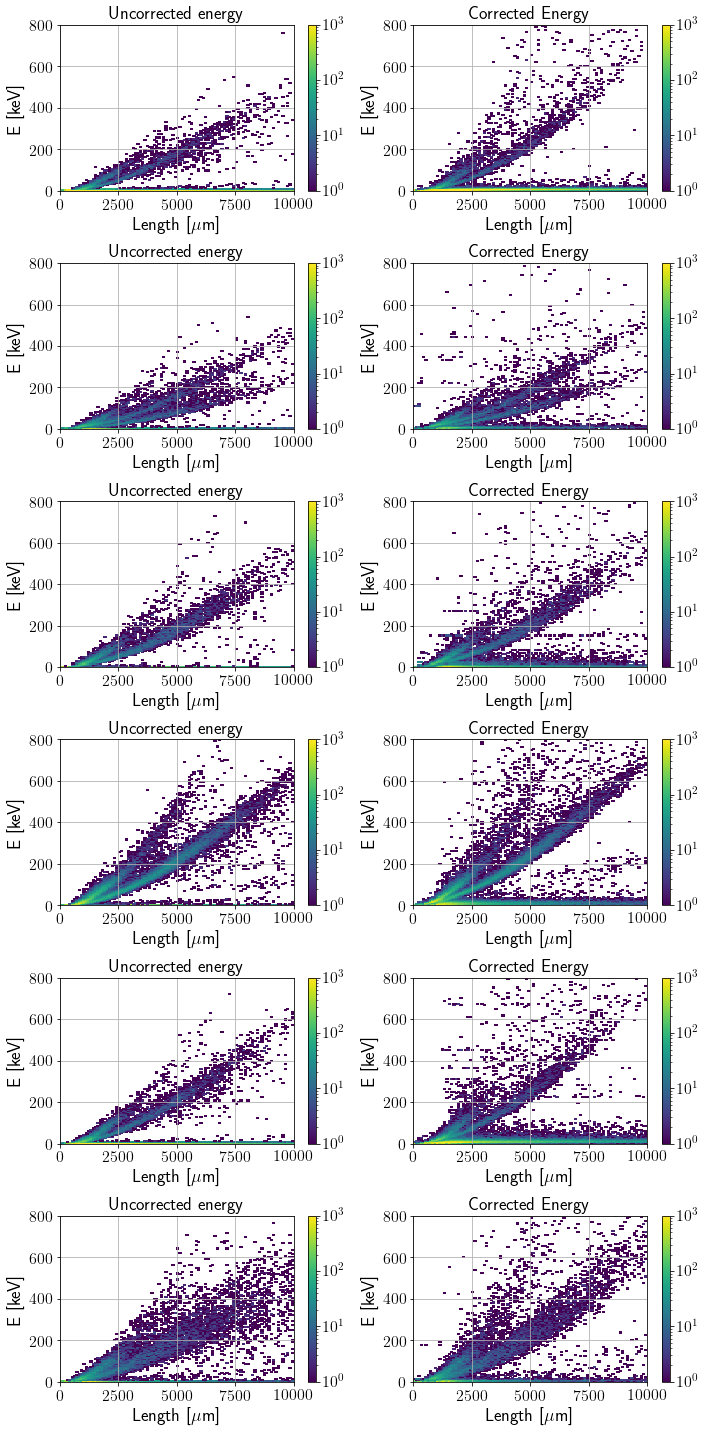

In [10]:
import matplotlib
i = 1
fig = plt.figure(figsize = (10,20))
cmap = plt.cm.viridis
cmap.set_under(color='white')
#vmin = 0.1
xm = 10000
ym = 800
nbinsx = 100
nbinsy = 160
h = {}
image = {}
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    x_plt = np.linspace(0,20000,20001)
    plt.subplot(6,2,i)
    x = np.array([1700, 2500, 5000])
    if tpc == 'iiwi':
        ymin = np.array([18, 40, 135])
        ymax = np.array([35, 70, 240])
    elif tpc == 'humu':
        ymin = np.array([15, 35, 118])
        ymax = np.array([35, 70, 200])
    elif tpc == 'nene':
        ymin = np.array([15, 35, 130])
        ymax = np.array([35, 76, 230])
    elif tpc == 'tako':
        ymin = np.array([18, 40, 150])
        ymax = np.array([38, 80, 265])
    elif tpc == 'palila':
        ymin = np.array([18, 40, 150])
        ymax = np.array([37, 80, 265])
    else:
        ymin = np.array([12, 24, 100])
        ymax = np.array([38, 75, 265])
    cut_min = np.polyfit(x,ymin, 2)
    cut_max = np.polyfit(x, ymax, 2)
    h[tpc+'_uncor'], xedges, yedges, image[tpc+'_uncor'] = plt.hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
    #plt.fill_between(x_plt, cut_min[0]*x_plt**2+cut_min[1]*x_plt+cut_min[2], cut_max[0]*x_plt**2+cut_max[1]*x_plt+cut_max[2], color = 'magenta', linewidth = 2, alpha = 0.3, label = 'He recoil training region')
    plt.ylim(0,ym)
    plt.xlim(0,xm)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    plt.title('%s Uncorrected energy vs length'%(tpc.upper()))
    plt.title('Uncorrected energy')
    custom_lines = [Line2D([0], [0], marker='o', color='tab:blue', label='Data', markersize=4, markerfacecolor='tab:blue', linewidth = 0),
                    Patch(color='magenta', linewidth = 2,
                         label='He recoil training region', alpha = 0.2)]
    #plt.legend(handles = custom_lines)
    plt.colorbar()
    plt.grid(which = 'both')
    #plt.show()
    plt.subplot(6,2,i+1)
    if tpc == 'iiwi':
        ymin = np.array([21, 50, 170])
        ymax = np.array([45, 85, 280])
    elif tpc == 'humu':
        ymin = np.array([25, 55, 160])
        ymax = np.array([45, 85, 255])
    elif tpc == 'nene':
        ymin = np.array([23, 45, 160])
        ymax = np.array([50, 90, 300])
    elif tpc == 'tako':
        ymin = np.array([30, 56, 190])
        ymax = np.array([60, 110, 330])
    elif tpc == 'palila':
        ymin = np.array([24, 52, 194])
        ymax = np.array([48, 96, 330])
    else:
        ymin = np.array([18, 38, 125])
        ymax = np.array([58, 102, 320])
    cut_min2 = np.polyfit(x,ymin, 2)
    cut_max2 = np.polyfit(x, ymax, 2)
    h[tpc+'_cor'], xedges, yedges, image[tpc+'_cor'] = plt.hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
    #plt.fill_between(x_plt, cut_min2[0]*x_plt**2+cut_min2[1]*x_plt+cut_min2[2], cut_max2[0]*x_plt**2+cut_max2[1]*x_plt+cut_max2[2], color = 'magenta', linewidth = 2, alpha = 0.3, label = 'He recoil training region')
    plt.ylim(0,ym)
    plt.xlim(0,xm)
    plt.title('%s Corrected energy vs length'%(tpc.upper()))
    plt.title('Corrected Energy')
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    #custom_lines = [Line2D([0], [0], marker='o', color='tab:blue', label='Data', markersize=4, markerfacecolor='tab:blue', linewidth = 0),Patch(color='magenta', linewidth = 2,label='He recoil training region', alpha = 0.3)]
    #plt.legend(handles = custom_lines)
    plt.colorbar()
    plt.grid(which = 'both')
    i+=2
    #plt.show()
#plt.savefig('EvL_cuts_zoom.png')
plt.tight_layout()
plt.show()

### Money plot

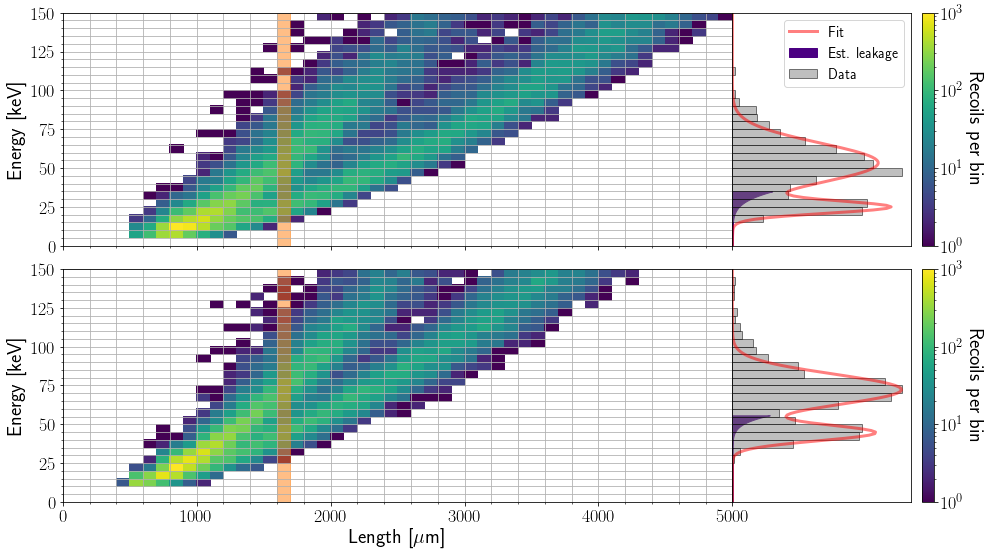

In [14]:
def gauss(x,mu,sigma,A): # for gaussian fit
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

x_plt = np.linspace(0,800,801)
bins = 0.5*(yedges[1:]+yedges[:-1])
sig_factor = 2 #Amount of sigmas away from Helium peak to define cutoff of leakage region

for tpc in ['tako']:
    for loc in range(16,17):
        ekey = 'track_energy'
        index_He = uncorrected_red[tpc].loc[(uncorrected_red[tpc]['length'] < (xedges[loc+1])) & (uncorrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc].index.isin(index_He) == False) & (uncorrected_recoils[tpc]['length'] < (xedges[loc+1])) & (uncorrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        plt.rc('legend', fontsize=14)
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        plt.rc('axes', labelsize=20)
        plt.rc('axes', titlesize=20)
        fig, ax = plt.subplots(2,2, figsize = (16,9), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [3, 1]})
        ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,150)
        ax[0,0].set_xlim(0,5000)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        par1 = uncorrected_red[tpc][ekey][index_He].mean()
        par2 = uncorrected_red[tpc][ekey][index_He].std()
        par3 = len(uncorrected_red[tpc][ekey][index_He])
        par4 = uncorrected_recoils[tpc][ekey][index_CO].mean()
        par5 = uncorrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(uncorrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        htest, xe, ye = np.histogram2d(uncorrected_recoils[tpc].loc[uncorrected_recoils[tpc][ekey]>(par1+sig_factor*par2)]['length'], uncorrected_recoils[tpc].loc[uncorrected_recoils[tpc][ekey]>(par1+sig_factor*par2)][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][loc], seed_params)
        gparams, gcov = curve_fit(gauss, bins, htest[loc], [par4,par5,par6])
        ax[0,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=3,label='Fit', alpha = 0.5)
        leak_plt = np.linspace(0,par1+sig_factor*par2,1000)
        ax[0,1].barh(bins, h[tpc+'_uncor'][loc], height = ym/nbinsy, alpha = 0.5, color = 'gray', label = 'Data',edgecolor = 'black')
        ax[0,1].fill_betweenx(leak_plt, 0, gauss(leak_plt,*gparams), color = 'indigo', label = 'Est. leakage')
        ax[0,1].set_ylim(0,150)
        #ax[0,1].set_xlim(0,220)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])
        ax[0,1].legend()

        ekey = 'full_corrected_energy'
        index_He = corrected_red[tpc].loc[(corrected_red[tpc]['length'] < (xedges[loc+1])) & (corrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = corrected_recoils[tpc].loc[(corrected_recoils[tpc].index.isin(index_He) == False) & (corrected_recoils[tpc]['length'] < (xedges[loc+1])) & (corrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,1000,2000,3000,4000, 5000, 6000])
        ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,150)
        ax[1,0].set_xlim(0,5000)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        par1 = corrected_red[tpc][ekey][index_He].mean()
        par2 = corrected_red[tpc][ekey][index_He].std()
        par3 = len(corrected_red[tpc][ekey][index_He])
        par4 = corrected_recoils[tpc][ekey][index_CO].mean()
        par5 = corrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(corrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        htest, xe, ye = np.histogram2d(corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(par1+sig_factor*par2)]['length'], corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(par1+sig_factor*par2)][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][loc], seed_params)
        gparams, gcov = curve_fit(gauss, bins, htest[loc], [par4,par5,par6])
        ax[1,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=3,label='fit', alpha = 0.5)
        leak_plt = np.linspace(0,par1+sig_factor*par2,1000)
        ax[1,1].fill_betweenx(leak_plt, 0, gauss(leak_plt,*gparams), color = 'indigo')
        ax[1,1].barh(bins, h[tpc+'_cor'][loc], height = ym/nbinsy, alpha = 0.5, color = 'gray', edgecolor = 'black')
        ax[1,1].set_ylim(0,150)
        #ax[1,1].set_xlim(0,220)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
        plt.savefig('money2.png')
plt.show()

### Generate a bunch of plots for validation

In [7]:
def gauss(x,mu,sigma,A): # for gaussian fit
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

x_plt = np.linspace(0,800,801)
bins = 0.5*(yedges[1:]+yedges[:-1])

for tpc in ['iiwi', 'nene', 'tako', 'palila']:
    for loc in range(25,60):
        ekey = 'track_energy'
        index_He = uncorrected_red[tpc].loc[(uncorrected_red[tpc]['length'] < (xedges[loc+1])) & (uncorrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc].index.isin(index_He) == False) & (uncorrected_recoils[tpc]['length'] < (xedges[loc+1])) & (uncorrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        fig, ax = plt.subplots(2,2, figsize = (8,7), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [3, 1]})
        ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,ym)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        par1 = uncorrected_red[tpc][ekey][index_He].mean()
        par2 = uncorrected_red[tpc][ekey][index_He].std()
        par3 = len(uncorrected_red[tpc][ekey][index_He])
        par4 = uncorrected_recoils[tpc][ekey][index_CO].mean()
        par5 = uncorrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(uncorrected_recoils[tpc][ekey][index_CO])
        print(loc, par3, par6)
        seed_params = [par1,par2,par3,par4,par5,par6]
        ax[0,1].barh(bins, h[tpc+'_uncor'][loc], height = ym/nbinsy)
        if 5*par6 < par3:
            if par3>20:
                seed_params = [uncorrected_recoils[tpc][ekey].mean(),uncorrected_recoils[tpc][ekey].std(),len(uncorrected_recoils[tpc][ekey])]
                try:
                    params , cov = curve_fit(gauss, bins, h[tpc+'_uncor'][loc], seed_params)
                    ax[0,1].plot(gauss(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
            else:
                pass
        else:
            if par3>20:
                try:
                    params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][loc], seed_params)
                    ax[0,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
            else:
                pass
        ax[0,1].set_ylim(0,ym)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])

        ekey = 'full_corrected_energy'
        index_He = corrected_red[tpc].loc[(corrected_red[tpc]['length'] < (xedges[loc+1])) & (corrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = corrected_recoils[tpc].loc[(corrected_recoils[tpc].index.isin(index_He) == False) & (corrected_recoils[tpc]['length'] < (xedges[loc+1])) & (corrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,2000,4000,6000,8000])
        ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,ym)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        par1 = corrected_red[tpc][ekey][index_He].mean()
        par2 = corrected_red[tpc][ekey][index_He].std()
        par3 = len(corrected_red[tpc][ekey][index_He])
        par4 = corrected_recoils[tpc][ekey][index_CO].mean()
        par5 = corrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(corrected_recoils[tpc][ekey][index_CO])
        print(loc, par3, par6)
        seed_params = [par1,par2,par3,par4,par5,par6]
        if par3 > 20:
            if 5*par6 < par3:
                if par3 > 20:
                    seed_params = [corrected_recoils[tpc][ekey].mean(),corrected_recoils[tpc][ekey].std(),len(corrected_recoils[tpc][ekey])]
                    try:
                        params , cov = curve_fit(gauss, bins, h[tpc+'_cor'][loc], seed_params)
                        ax[1,1].plot(gauss(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                    except RuntimeError:
                        pass
                else:
                    pass
            else:
                try:
                    params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][loc], seed_params)
                    ax[1,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
        else:
            pass
        ax[1,1].barh(bins, h[tpc+'_cor'][loc], height = ym/nbinsy)
        ax[1,1].set_ylim(0,ym)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
        plt.savefig('%s_hist_%s.png'%(tpc, loc))
        plt.clf()

NameError: name 'yedges' is not defined

In [ ]:
import scipy.integrate as integrate
def get_resolution_and_leakage(xmax = 10000, ymax = 800, nbinsx = 100, nbinsy = 80, tpcs = ['iiwi', 'nene', 'tako', 'palila']):
    h = {}
    image = {}
    reso_dfs = {}
    sig_factor = 2
    for tpc in tpcs:
        resolution = {}
        h[tpc+'_uncor'], xedges, yedges, image[tpc+'_uncor'] = plt.hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xmax),(0,ymax)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        h[tpc+'_cor'], xedges, yedges, image[tpc+'_cor'] = plt.hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xmax),(0,ymax)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.clf()
        bins = 0.5*(yedges[1:]+yedges[:-1])
        resolution['length'] = []
        resolution['energy_uncor'] = []
        resolution['energy_uncor_err'] = []
        resolution['energy_cor'] = []
        resolution['energy_cor_err'] = []
        resolution['reso_uncor'] = []
        resolution['reso_uncor_err'] = []
        resolution['reso_cor'] = []
        resolution['reso_cor_err'] = []
        resolution['leakage_uncor'] = [] #leakage from C/O band into He band
        resolution['leakage_cor'] = []
        resolution['leakage_uncor_err'] = []
        resolution['leakage_cor_err'] = []
        dx = xedges[1]-xedges[0]
        imin = int(1400/dx)
        imax = nbinsx
        for i in range(imin,imax):
            resolution['length'].append((xedges[i+1]+xedges[i])/2)
            for ekey in ['track_energy', 'full_corrected_energy']:
                if ekey == 'track_energy':
                    df = uncorrected_recoils[tpc]
                    df_red = uncorrected_red[tpc]
                else:
                    df = corrected_recoils[tpc]
                    df_red = corrected_red[tpc]
                index_He = df_red.loc[(df_red['length'] < (xedges[i+1])) & (df_red['length'] > (xedges[i]))].index.to_numpy()
                index_CO = df.loc[(df.index.isin(index_He) == False) & (df['length'] < (xedges[i+1])) & (df['length'] > (xedges[i]))].index.to_numpy()
                par1 = df_red[ekey][index_He].mean()
                par2 = df_red[ekey][index_He].std()
                par3 = len(df_red[ekey][index_He])
                par4 = df[ekey][index_CO].mean()
                par5 = df[ekey][index_CO].std()
                par6 = len(df[ekey][index_CO])
                seed_params = [par1,par2,par3,par4,par5,par6]
                def gauss(x,mu,sigma,A): # for gaussian fit
                    return A*exp(-(x-mu)**2/2/sigma**2)
                def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
                    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
                if 5*par6 < par3:
                    if par3>20:
                        seed_params = [df[ekey].mean(),df[ekey].std(),len(df[ekey])]
                        try:
                            if ekey == 'track_energy':
                                params , cov = curve_fit(gauss, bins, h[tpc+'_uncor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_uncor'].append(reso)
                                resolution['reso_uncor_err'].append(reso_err)
                                resolution['energy_uncor'].append(energy)
                                resolution['energy_uncor_err'].append(energy_err)
                                resolution['leakage_uncor'].append(np.nan)
                                resolution['leakage_uncor_err'].append(np.nan)
                            else:
                                params , cov = curve_fit(gauss, bins, h[tpc+'_cor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_cor'].append(reso)
                                resolution['reso_cor_err'].append(reso_err)
                                resolution['energy_cor'].append(energy)
                                resolution['energy_cor_err'].append(energy_err)
                                resolution['leakage_cor'].append(np.nan)
                                resolution['leakage_cor_err'].append(np.nan)
                        except RuntimeError:
                            if ekey == 'track_energy':
                                resolution['reso_uncor'].append(np.nan)
                                resolution['reso_uncor_err'].append(np.nan)
                                resolution['energy_uncor'].append(np.nan)
                                resolution['energy_uncor_err'].append(np.nan)
                                resolution['leakage_uncor'].append(np.nan)
                                resolution['leakage_uncor_err'].append(np.nan)
                            else:
                                resolution['reso_cor'].append(np.nan)
                                resolution['reso_cor_err'].append(np.nan)
                                resolution['energy_cor'].append(np.nan)
                                resolution['energy_cor_err'].append(np.nan)
                                resolution['leakage_cor'].append(np.nan)
                                resolution['leakage_cor_err'].append(np.nan)
                    else:
                        if ekey == 'track_energy':
                            resolution['reso_uncor'].append(np.nan)
                            resolution['reso_uncor_err'].append(np.nan)
                            resolution['energy_uncor'].append(np.nan)
                            resolution['energy_uncor_err'].append(np.nan)
                            resolution['leakage_uncor'].append(np.nan)
                            resolution['leakage_uncor_err'].append(np.nan)
                        else:
                            resolution['reso_cor'].append(np.nan)
                            resolution['reso_cor_err'].append(np.nan)
                            resolution['energy_cor'].append(np.nan)
                            resolution['energy_cor_err'].append(np.nan)
                            resolution['leakage_cor'].append(np.nan)
                            resolution['leakage_cor_err'].append(np.nan)
                else:
                    if par3>20:
                        try:
                            if ekey == 'track_energy':
                                params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_uncor'].append(reso)
                                resolution['reso_uncor_err'].append(reso_err)
                                resolution['energy_uncor'].append(energy)
                                resolution['energy_uncor_err'].append(energy_err)
                                leakage = integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0]
                                leakage_err = leakage*np.sqrt((integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0])**2+(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0])**2)
                                resolution['leakage_uncor'].append(leakage)
                                resolution['leakage_uncor_err'].append(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1])
                            else:
                                params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_cor'].append(reso)
                                resolution['reso_cor_err'].append(reso_err)
                                resolution['energy_cor'].append(energy)
                                resolution['energy_cor_err'].append(energy_err)
                                leakage = integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0]
                                leakage_err = leakage*np.sqrt((integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0])**2+(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0])**2)
                                resolution['leakage_cor'].append(leakage)
                                resolution['leakage_cor_err'].append(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1])
                        except RuntimeError:
                            if ekey == 'track_energy':
                                resolution['reso_uncor'].append(np.nan)
                                resolution['reso_uncor_err'].append(np.nan)
                                resolution['energy_uncor'].append(np.nan)
                                resolution['energy_uncor_err'].append(np.nan)
                                resolution['leakage_uncor'].append(np.nan)
                                resolution['leakage_uncor_err'].append(np.nan)
                            else:
                                resolution['reso_cor'].append(np.nan)
                                resolution['reso_cor_err'].append(np.nan)
                                resolution['energy_cor'].append(np.nan)
                                resolution['energy_cor_err'].append(np.nan)
                                resolution['leakage_cor'].append(np.nan)
                                resolution['leakage_cor_err'].append(np.nan)
                    else:
                        if ekey == 'track_energy':
                            resolution['reso_uncor'].append(np.nan)
                            resolution['reso_uncor_err'].append(np.nan)
                            resolution['energy_uncor'].append(np.nan)
                            resolution['energy_uncor_err'].append(np.nan)
                            resolution['leakage_uncor'].append(np.nan)
                            resolution['leakage_uncor_err'].append(np.nan)
                        else:
                            resolution['reso_cor'].append(np.nan)
                            resolution['reso_cor_err'].append(np.nan)
                            resolution['energy_cor'].append(np.nan)
                            resolution['energy_cor_err'].append(np.nan)
                            resolution['leakage_cor'].append(np.nan)
                            resolution['leakage_cor_err'].append(np.nan)
        reso_dfs[tpc] = pd.DataFrame.from_dict(resolution)
    return reso_dfs
    

In [ ]:
dfs = get_resolution_and_leakage(nbinsx = 100, nbinsy = 160)
for tpc in dfs.keys():
    dfs[tpc] = dfs[tpc].loc[(np.abs(dfs[tpc]['reso_uncor_err'])<2*np.abs(dfs[tpc]['reso_uncor'])) & (np.abs(dfs[tpc]['reso_cor_err'])<2*np.abs(dfs[tpc]['reso_cor']))]# & (np.abs(dfs[tpc]['leakage_cor'])<.4) & (np.abs(dfs[tpc]['leakage_uncor'])<.40)]

### Leakage plot for tako

In [ ]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
for tpc in ['tako']:
    fig, ax = plt.subplots(figsize = (10,8))
    index = dfs[tpc].loc[dfs[tpc]['length']<3900].index.to_numpy()
    #ax.errorbar(dfs[tpc]['length'],np.abs(dfs[tpc]['reso_uncor']),np.abs(dfs[tpc]['reso_uncor_err']),[0 for i in range(0,len(dfs[tpc]))], 'o', color = 'red', label = 'Uncorrected')
    #p1 = ax.errorbar(dfs[tpc]['length'],np.abs(dfs[tpc]['reso_cor']),np.abs(dfs[tpc]['reso_cor_err']),[0 for i in range(0,len(dfs[tpc]))], 'o', color = 'indigo', label = 'Resolution', markeredgecolor = 'black')
    p1 = ax.errorbar(dfs[tpc]['energy_cor'],np.abs(dfs[tpc]['reso_cor']),np.abs(dfs[tpc]['reso_cor_err']),dfs[tpc]['energy_cor_err'], 'o', color = 'indigo', label = 'Resolution', markeredgecolor = 'black')
    ax.set_ylabel(r'$\sigma_E/E$')
    #ax.set_xlabel(r'length [$\mu$m]')
    #ax.set_xlim(0,7000)
    ax.set_xlabel(r'$E_{recoil}$ [keV]')
    ax.set_xlim(0,400)
    ax.set_ylim(0,0.2)
    ax.grid()
    ax2 = ax.twinx()
    #plt.plot(dfs[tpc]['length'],np.abs(dfs[tpc]['leakage_uncor'])*100, 'o', color = 'red', label = 'Uncorrected')
    #p2 = ax2.plot(dfs[tpc]['length'][index],np.abs(dfs[tpc]['leakage_cor'][index])*100, 's', color = 'blue', label = 'Leakage', markeredgecolor = 'black')
    p2 = ax2.plot(dfs[tpc]['energy_cor'][index], np.abs(dfs[tpc]['leakage_cor'][index])*100, 's', color = 'blue', label = 'Leakage', markeredgecolor = 'black')
    ax2.set_ylabel(r'Leakage percentage [$\%$]')
    #plt.title(tpc)
    ax2.set_ylim(0,20)
    ax2.grid()
    markers = [p1, p2[0]]
    plt.legend(markers, [m.get_label() for m in markers])
plt.tight_layout()
#plt.savefig('tako_leakage.png')
plt.show()

In [ ]:
p2[0].get_label()

In [ ]:
i=1
plt.figure(figsize = (10,8))
for tpc in dfs.keys():
    plt.subplot(2,2,i)
    plt.errorbar(dfs[tpc]['length'],np.abs(dfs[tpc]['reso_uncor']),np.abs(dfs[tpc]['reso_uncor_err']),[0 for i in range(0,len(dfs[tpc]))], 'o', color = 'red', label = 'Uncorrected')
    plt.errorbar(dfs[tpc]['length'],np.abs(dfs[tpc]['reso_cor']),np.abs(dfs[tpc]['reso_cor_err']),[0 for i in range(0,len(dfs[tpc]))], 'o', color = 'blue', label = 'Corrected')
    plt.xlabel(r'length [$\mu$m]')
    plt.ylabel(r'$\sigma_E/E$')
    plt.title(tpc)
    #plt.ylim(0,0.25)
    #plt.xlim(0,7000)
    plt.grid()
    plt.legend()
    i+=1
plt.tight_layout()
#plt.savefig('he_reso_new.png')
plt.show()

### Estimate Leakage

In [ ]:
import scipy.integrate as integrate

def gauss(x,mu,sigma,A): # for gaussian fit
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

x_plt = np.linspace(0,800,801)
bins = 0.5*(yedges[1:]+yedges[:-1])
sig_factor = 2 #Amount of sigmas away from Helium peak to define cutoff of leakage region
leakage = {}
for tpc in ['tako']:
    leakage[tpc+'_uncor'] = []
    leakage[tpc+'_cor'] = []
    for loc in range(16,17):
        ekey = 'track_energy'
        index_He = uncorrected_red[tpc].loc[(uncorrected_red[tpc]['length'] < (xedges[loc+1])) & (uncorrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc].index.isin(index_He) == False) & (uncorrected_recoils[tpc]['length'] < (xedges[loc+1])) & (uncorrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        plt.rc('legend', fontsize=14)
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        plt.rc('axes', labelsize=20)
        plt.rc('axes', titlesize=20)
        fig, ax = plt.subplots(2,2, figsize = (11,9), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [2.5, 1]})
        ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,150)
        ax[0,0].set_xlim(0,5000)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        par1 = uncorrected_red[tpc][ekey][index_He].mean()
        par2 = uncorrected_red[tpc][ekey][index_He].std()
        par3 = len(uncorrected_red[tpc][ekey][index_He])
        par4 = uncorrected_recoils[tpc][ekey][index_CO].mean()
        par5 = uncorrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(uncorrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        htest, xe, ye = np.histogram2d(uncorrected_recoils[tpc].loc[uncorrected_recoils[tpc][ekey]>(par1+sig_factor*par2)]['length'], uncorrected_recoils[tpc].loc[uncorrected_recoils[tpc][ekey]>(par1+sig_factor*par2)][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][loc], seed_params)
        leakage[tpc+'_uncor'].append(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0])
        gparams, gcov = curve_fit(gauss, bins, htest[loc], [par4,par5,par6])
        ax[0,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=3,label='Fit', alpha = 0.5)
        leak_plt = np.linspace(0,par1+sig_factor*par2,1000)
        ax[0,1].barh(bins, h[tpc+'_uncor'][loc], height = ym/nbinsy, alpha = 0.5, color = 'gray', label = 'Data',edgecolor = 'black')
        ax[0,1].fill_betweenx(leak_plt, 0, gauss(leak_plt,*gparams), color = 'indigo', label = 'Est. leakage')
        ax[0,1].set_ylim(0,150)
        ax[0,1].set_xlim(0,150)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])
        ax[0,1].legend()

        ekey = 'full_corrected_energy'
        index_He = corrected_red[tpc].loc[(corrected_red[tpc]['length'] < (xedges[loc+1])) & (corrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = corrected_recoils[tpc].loc[(corrected_recoils[tpc].index.isin(index_He) == False) & (corrected_recoils[tpc]['length'] < (xedges[loc+1])) & (corrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,1000,2000,3000,4000, 5000])
        ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,150)
        ax[1,0].set_xlim(0,5000)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        par1 = corrected_red[tpc][ekey][index_He].mean()
        par2 = corrected_red[tpc][ekey][index_He].std()
        par3 = len(corrected_red[tpc][ekey][index_He])
        par4 = corrected_recoils[tpc][ekey][index_CO].mean()
        par5 = corrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(corrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        htest, xe, ye = np.histogram2d(corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(par1+sig_factor*par2)]['length'], corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(par1+sig_factor*par2)][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        htest2, xe, ye = np.histogram2d(corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]<(par1+sig_factor*par2)]['length'], corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]<(par1+sig_factor*par2)][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][loc], seed_params)
        leakage[tpc+'_cor'].append(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0])
        htest, xe, ye = np.histogram2d(corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(params[0]+sig_factor*params[1])]['length'], corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(params[0]+sig_factor*params[1])][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        htest2, xe, ye = np.histogram2d(corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]<(params[0]+sig_factor*params[1])]['length'], corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]<(params[0]+sig_factor*params[1])][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        gparams, gcov = curve_fit(gauss, bins, htest[loc], [params[3],params[4],params[5]])
        ax[1,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=3,label='fit', alpha = 0.5)
        leak_plt = np.linspace(0,par1+sig_factor*par2,1000)
        ax[1,1].fill_betweenx(leak_plt, 0, gauss(leak_plt,*gparams), color = 'indigo')
        ax[1,1].barh(bins, h[tpc+'_cor'][loc], height = ym/nbinsy, alpha = 0.5, color = 'gray', edgecolor = 'black')
        ax[1,1].set_ylim(0,150)
        ax[1,1].set_xlim(0,150)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
        plt.savefig('money.png')
plt.show()

In [ ]:
import scipy.integrate as integrate
integrate.quad(gauss, 0, par1+sig_factor*par2, args = (par4,par5,par6))[0]/integrate.quad(gauss, 0, par1+sig_factor*par2, args = (par1,par2,par3))[0]



In [ ]:
gparams2, gcov2 = curve_fit(gauss, bins, htest2[loc], [params[0],params[1],params[2]])
plt.bar(bins, h[tpc+'_cor'][loc], width = ym/nbinsy, alpha = 0.5)
plt.plot(x_plt, gauss(x_plt,*gparams), lw = 2, color = 'red')

In [ ]:
integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (gparams[0],gparams[1],gparams[2]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (gparams2[0],gparams2[1],gparams2[2]))[0]

In [ ]:
integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0]